# Branching ratios with uncertainties
The goal of this notebook is to calculate the branching ratios and their uncertainties for spontaneous decay from the $B^3\Pi_1$ state of TlF.

Import packages:

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pickle
import numpy as np
import sympy
from numpy.random import normal
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

#Custom classes for defining molecular states and some convenience functions for them
sys.path.append('./molecular-state-classes-and-functions/')
from classes import UncoupledBasisState, CoupledBasisState, State
from functions import (make_hamiltonian, make_hamiltonian_B, make_QN, ni_range, vector_to_state,
                        find_state_idx_from_state, make_transform_matrix, matrix_to_states, reorder_evecs)

#Some useful extra functions
from extra_functions import calculate_BR, find_exact_states, find_exact_states_V

## X-state hamiltonian
Generate Hamiltonian for X-state

In [2]:
#Load Hamiltonian from file
H_X_uc = make_hamiltonian("./Saved Hamiltonians/TlF_X_state_hamiltonian_J0to4.pickle")

#Hamiltonian on file is in uncoupled angular momentum basis. Transform it to coupled.
#Load transform matrix
with open("./Saved Hamiltonians/UC_to_C_j0to4.pickle","rb") as f:
    S_trans = pickle.load(f)

#Transform matrix
E = np.array((0,0,0))
B = np.array((0,0,0.001)) #Very small magnetic field is used to ensure mF is a good quantum number 
H_X =  S_trans.conj().T @ H_X_uc(E, B) @ S_trans

#Define basis to which the Hamiltonian was transformed
Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2
QN_X = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
    for J  in ni_range(Jmin, Jmax+1)
    for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
    for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
    for mF in ni_range(-F, F+1)
    ]

#Diagonalize the Hamiltonian (also making sure V is as close as identity matrix as possible
# in terms of ordering of states)
D, V = np.linalg.eigh(H_X)
V_ref_X = np.eye(V.shape[0])
D, V = reorder_evecs(V,D,V_ref_X)
H_X_diag = V.conj().T @ H_X @ V

#Define new basis based on eigenstates of H_X:
QN_X_diag = matrix_to_states(V, QN_X)

In [3]:
#Define what states are to be included in the simulation
Js_g = [0,1,2,3,4] # J values to be included
I_F = 1/2 #Fluorine nuclear spin
I_Tl = 1/2 #Thallium nuclear spin

#Generate a list of approximate ground states
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]
ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

#Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 1
#Generate a list of excited states
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

## B-state Hamiltonian
Generate Hamiltonian for B-state

In [4]:
#Define the basis that the Hamiltonian is in
Jmin = 1
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1, 1]
QN_B = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B')
    for J  in ni_range(Jmin, Jmax+1)
    for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
    for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
    for mF in ni_range(-F, F+1)
    for P in Ps
    ]

In [5]:
#Load Hamiltonian from file
# path = "./Saved Hamiltonians/B_state_hamiltonian_J1to5_P_estates_separate.pickle"
# path = "./Saved Hamiltonians/B_state_hamiltonian_J1to3_P_estates_separate.pickle"
path = "./Saved Hamiltonians/B_hamiltonians_symbolic_coupled_P_1to3.pickle"


with open(path, 'rb') as f:
    hamiltonians = pickle.load(f)

    variables = [
        *sympy.symbols('Brot Drot H_const'),
        *sympy.symbols('h1_Tl h1_F'),
        sympy.symbols('q'),
        sympy.symbols('c_Tl'),
        sympy.symbols('c1p_Tl'),
        sympy.symbols('mu_B'),
        *sympy.symbols('gS gL')
    ]

    lambdified_hamiltonians = {
        H_name : sympy.lambdify(variables, H_matrix)
        for H_name, H_matrix in hamiltonians.items()
    }

    #Constants in MHz
    Brot = 1
    Drot = 0
    H_const = 0
    h1_Tl = 1
    h1_F = 1
    q = 1
    c_Tl = 1
    c1p_Tl = 1
    mu_B = 1
    gL = 1
    gS = 2

    Hams_B = {
        H_name : H_fn(
            Brot, Drot, H_const,
            h1_Tl, h1_F,
            q,
            c_Tl,
            c1p_Tl,
            mu_B,
            gS, gL
        )
        for H_name, H_fn in lambdified_hamiltonians.items()
    }

In [6]:
Hams_B.keys()

dict_keys(['Hrot', 'H_mhf_Tl', 'H_mhf_F', 'H_LD', 'H_cp1_Tl', 'H_c_Tl', 'HZz'])

In [8]:
for key in list(Hams_B.keys()):
    print(Hams_B[key].shape)

(120, 120)
(120, 120)
(120, 120)
(120, 120)
(120, 120)
(120, 120)
(120, 120)


In [10]:
# Define a function that generates the B-state Hamiltonian for given constants
def make_B_hamiltonian(H, Brot, h1_Tl, h1_F, q, c_Tl, c1p_Tl):
    H_B = (2*np.pi*(Brot*H["Hrot"] +h1_Tl*H["H_mhf_Tl"]+h1_F*H["H_mhf_F"]+c_Tl*H["H_c_Tl"]
                    +c1p_Tl*H["H_cp1_Tl"]+q*H["H_LD"]+H["HZz"]*1))
           
    return H_B

# def make_B_hamiltonian(H, Brot, Drot, H_const, h1_Tl, h1_F, q, c_Tl, c1p_Tl):
#     H_B = (2*np.pi*(Brot*H["J2"] - Drot*H["J4"] + H_const*H["J6"]+h1_Tl*H["H_mhf_Tl"]+h1_F*H["H_mhf_F"]+c_Tl*H["H_c_Tl"]
#                     +c1p_Tl*H["H_cp1_Tl"]+q*H["H_LD"]+H["HZz"]*1))
           
#     return H_B
           
# Define a function that calculates branching ratio for given excited state and the uncertainty in it
# by repeatedly diagonalizing the B-state Hamiltonian
def calculate_br_and_error(Ntrials = 1000):
    #Define arrays of parameters
    Brot = normal(6687.879e6,0.0026e6, size = Ntrials)
    Drot = normal(0.010869e6,0.000027e6, size = Ntrials)
    H_const = normal(-8.1,0.6, size = Ntrials)*1e-2
    h1_Tl = normal(28789e6,42e6, size = Ntrials)
    h1_F = normal(861e6,20e6, size = Ntrials)
    q = normal(2.423e6,0, size = Ntrials)
    c_Tl = normal(-7.83e6,1.57e6, size = Ntrials)
    c1p_Tl = normal(11.17e6,3e6, size = Ntrials)
           
    BRs_F0 = []
    BRs_F1 = []
    for i in tqdm(range(0, Ntrials)):
#         H_B = make_B_hamiltonian(Hams_B, Brot[i], Drot[i], H_const[i], h1_Tl[i], h1_F[i], q[i], c_Tl[i], c1p_Tl[i])
        H_B = make_B_hamiltonian(Hams_B, Brot[i], h1_Tl[i], h1_F[i], q[i], c_Tl[i], c1p_Tl[i])

        #Diagonalize the Hamiltonian
        D,V = np.linalg.eigh(H_B)
        tol = 1e-3
        V[np.abs(V) < tol] = 0
        V_ref_B = np.eye(H_B.shape[0])
        D, V = reorder_evecs(V,D,V_ref_B)
        H_B_diag = V.conj().T @ H_B @ V
                
        #Find exact eigenstates for excited state
        J = 1
        F1 = 3/2
        F = 1
        excited_states_approx = [1*CoupledBasisState(F,0,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)]
        excited_states = find_exact_states_V(excited_states_approx, H_B, V, QN_B, V_ref=V_ref_B)
                
        #Calculate branching ratios to all states from B, J = 1,  
        BRs = calculate_BR(excited_states[0],ground_states)
        
        #Find branching ratio to J = 0, F = 0:
        BRs_F0.append(BRs[0])
        
        #Find branching ratio to J = 0, F = 1:
        BRs_F1.append(BRs[1]+BRs[2]+BRs[3])
        
    return np.array(BRs_F0), np.array(BRs_F1)

In [11]:
BRs_F0, BRs_F1 = calculate_br_and_error(Ntrials=1000)

<IPython.core.display.Javascript object>


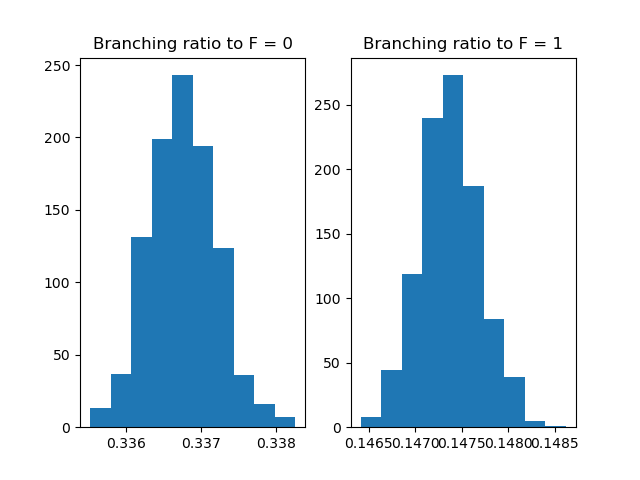

Text(0.5, 1.0, 'Branching ratio to F = 1')

In [275]:
# Plot histograms of the branching ratios
fig, ax = plt.subplots(1,2)
ax[0].hist(BRs_F0)
ax[0].set_title("Branching ratio to F = 0")
ax[1].hist(BRs_F1)
ax[1].set_title("Branching ratio to F = 1")


<IPython.core.display.Javascript object>


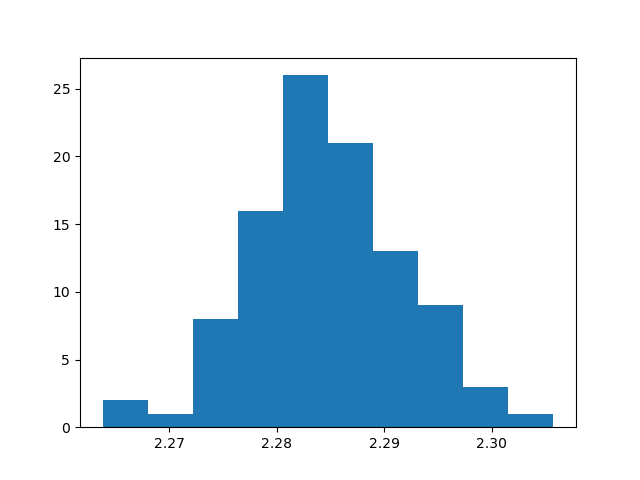

(array([ 2.,  1.,  8., 16., 26., 21., 13.,  9.,  3.,  1.]),
 array([2.26381366, 2.26800841, 2.27220315, 2.27639789, 2.28059263,
        2.28478737, 2.28898211, 2.29317685, 2.29737159, 2.30156633,
        2.30576107]),
 <a list of 10 Patch objects>)

In [269]:
fig, ax = plt.subplots()
ratios = BRs_F0/BRs_F1
ax.hist(ratios)

In [270]:
np.median(ratios)

2.2845375336500497

## Testing

In [271]:
#Constants in MHz
Brot = 6687.879e6
Drot = -0.010869e6
H_const = 8.1e-2
h1_Tl = 28789e6
h1_F = 861e6
q = 2.423e6
c_Tl = -7.83e6
c1p_Tl = 11.17e6
mu_B = 1
gL = 1
gS = 2

# H_B = make_hamiltonian_B("./Saved Hamiltonians/B_state_hamiltonian_J1to5_P_estates_separate.pickle")
# H_B = make_hamiltonian_B("./Saved Hamiltonians/B_hamiltonians_symbolic_coupled_P_1to3.pickle")

# H_B = make_B_hamiltonian(Hams_B, Brot, Drot, H_const, h1_Tl, h1_F, q, c_Tl, c1p_Tl)

# H_B = (2*np.pi*(Brot*Hams_B["J2"] - Drot*Hams_B["J4"] + H_const*Hams_B["J6"]+h1_Tl*Hams_B["H_mhf_Tl"]+h1_F*Hams_B["H_mhf_F"]
#                 +c_Tl*Hams_B["H_c_Tl"]+c1p_Tl*Hams_B["H_cp1_Tl"]+q*Hams_B["H_LD"]+Hams_B["HZz"]*1))

H_B = (2*np.pi*(Brot*Hams_B["Hrot"]+h1_Tl*Hams_B["H_mhf_Tl"]+h1_F*Hams_B["H_mhf_F"]
                +c_Tl*Hams_B["H_c_Tl"]+c1p_Tl*Hams_B["H_cp1_Tl"]+q*Hams_B["H_LD"]+Hams_B["HZz"]*1))

#Diagonalize the Hamiltonian
D,V = np.linalg.eigh(H_B)
# tol = 1e-3
# V[np.abs(V) < tol] = 0
V_ref_B = np.eye(H_B.shape[0])
D, V = reorder_evecs(V,D,V_ref_B)
H_B_diag = V.conj().T @ H_B @ V

#Define new basis based on eigenstates of H_B
QN_B_diag = matrix_to_states(V, QN_B)

#Find exact eigenstates for excited state
J = 1
F1 = 3/2
F = 1
excited_states_approx = [1*CoupledBasisState(F,0,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)]
# excited_states = find_exact_states_V(excited_states_approx, H_B, V, QN_B, V_ref=V_ref_B)
excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

excited_states[0].print_state()

#Calculate branching ratios to all states from B, J = 1,  
BRs = calculate_BR(excited_states[0],ground_states)

BR_F0 = BRs[0]
BR_F1 = np.sum(BRs[1:4])
print(BR_F0)
print(BR_F1)

+0.8518+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5233+0.0000j x |B, J = 2, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
0.33675471380743693
0.1473725963270553


In [272]:
H_B

array([[-9.00634295e+09,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -9.10697445e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.39979459e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.27428749e+11,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  5.27506164e+11,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  5.27428749e+11]])

In [273]:
H_B_correct

array([[-9.00661612e+09,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -9.10724762e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.40006776e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.27418914e+11,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  5.27496329e+11,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  5.27418914e+11]])

In [209]:
# D_correct = D
# H_B_correct = H_B

In [210]:
D_correct/(2*np.pi*1e9)

array([-1.43344748, -1.44946348, -0.86979794, -0.88578527, -0.86979794,
       -0.88578527, -0.86979794, -0.88578527, 12.63116625, 12.64887098,
       12.63116625, 12.64887098, 12.63116625, 12.64887098, 12.94799515,
       12.96597   , 12.94799516, 12.96597   , 12.94799516, 12.96597   ,
       12.94799516, 12.96597   , 12.94799516, 12.96597   , 40.29959543,
       40.31389404, 40.29959543, 40.31389404, 40.29959544, 40.31389404,
       40.88146456, 40.89550353, 40.88146457, 40.89550353, 40.88146457,
       40.89550353, 40.88146457, 40.89550353, 40.88146457, 40.89550353,
       39.6326908 , 39.61878525, 39.6326908 , 39.61878525, 39.6326908 ,
       39.61878525, 39.6326908 , 39.61878525, 39.63269081, 39.61878525,
       39.86305336, 39.84893432, 39.86305336, 39.84893432, 39.86305336,
       39.84893432, 39.86305336, 39.84893432, 39.86305336, 39.84893433,
       39.86305337, 39.84893433, 39.86305337, 39.84893433, 80.44398011,
       80.40985587, 80.44398012, 80.40985587, 80.44398012, 80.40

In [211]:
D/(2*np.pi*1e9)

array([-1.01869852, -1.01869852, -1.01869852, -1.01869852, -1.01869852,
       -1.01869852, -1.01869852, -1.01869852, 12.83852625, 12.83852625,
       12.83852625, 12.83852625, 12.83852625, 12.83852625, 12.83852625,
       12.83852625, 12.83852625, 12.83852625, 12.83852625, 12.83852625,
       12.83852625, 12.83852625, 12.83852625, 12.83852625, 40.66494053,
       40.66494053, 40.66494053, 40.66494053, 40.66494053, 40.66494053,
       40.66494052, 40.66494052, 40.66494053, 40.66494053, 40.66494053,
       40.66494053, 40.66494053, 40.66494053, 40.66494053, 40.66494053,
       39.76563821, 39.76563821, 39.76563821, 39.76563821, 39.76563821,
       39.76563821, 39.76563821, 39.76563821, 39.76563822, 39.76563822,
       39.76563821, 39.76563821, 39.76563821, 39.76563821, 39.76563821,
       39.76563821, 39.76563821, 39.76563821, 39.76563821, 39.76563821,
       39.76563822, 39.76563822, 39.76563822, 39.76563822, 80.61814036,
       80.61814036, 80.61814036, 80.61814036, 80.61814036, 80.61

In [182]:
H["H_mhf_Tl"]*h1_Tl

array([[-1.439450e+10,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00, -1.439450e+10,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00, -1.439450e+10, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       ...,
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  3.598625e+09,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         3.598625e+09,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  3.598625e+09]])

In [138]:
H["J4"]

array([[  4,   0,   0, ...,   0,   0,   0],
       [  0,   4,   0, ...,   0,   0,   0],
       [  0,   0,   4, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 144,   0,   0],
       [  0,   0,   0, ...,   0, 144,   0],
       [  0,   0,   0, ...,   0,   0, 144]])